<a href="https://colab.research.google.com/github/jmins33/ml_edu/blob/master/ml_clf/housing_price_prediction_%EC%8B%9C%EA%B0%81%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# kaggle.json을 아래 폴더로 옮긴 뒤, file을 사용할 수 있도록 권한을 부여한다. 
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
uploaded file "kaggle.json" with length 65 bytes


In [6]:
from google.colab import drive # 패키지 불러오기 
from os.path import join  

ROOT = "/content/drive"     # 드라이브 기본 경로
print(ROOT)                 # print content of ROOT (Optional)
drive.mount(ROOT)           # 드라이브 기본 경로 Mount

MY_GOOGLE_DRIVE_PATH = 'My Drive/Colab Notebooks/houseprice/' # 프로젝트 경로
PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH) # 프로젝트 경로
print(PROJECT_PATH)

/content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/houseprice/


In [7]:
%cd "{PROJECT_PATH}"

/content/drive/My Drive/Colab Notebooks/houseprice


In [8]:
!ls

sample_submission.csv  test.csv  train.csv


In [9]:
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from IPython.core.display import display, HTML
from pandas_profiling import ProfileReport

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [10]:
%matplotlib inline
import matplotlib.pylab as plt

plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = True 

In [16]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/houseprice/train.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/houseprice/test.csv')
print("data import is done")

data import is done


In [17]:
train.shape, test.shape

((1460, 81), (1459, 80))

In [18]:
display(train.head())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [19]:
numeric_features = train.select_dtypes(include=[np.number])
print(numeric_features.columns)
print("The total number of numeric features are: ", len(numeric_features.columns))

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
The total number of numeric features are:  38


In [20]:
categorical_features = train.select_dtypes(exclude=[np.number])
print(categorical_features.columns)
print("The total number of numeric features are: ", len(categorical_features.columns))

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
The total number of numeric features are:  43


In [21]:
year_fea = [fea for fea in numeric_features if 'Yr' in fea or 'Year' in fea]
print(year_fea)

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']


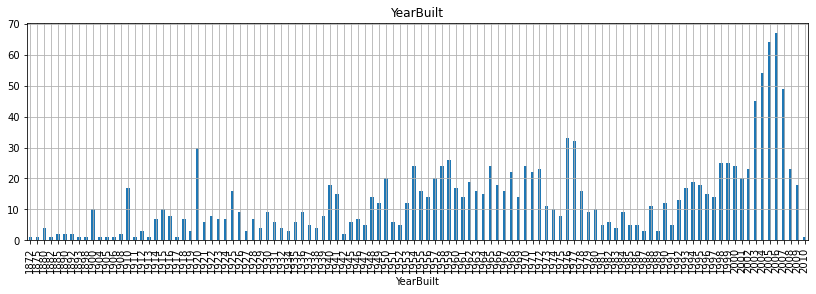

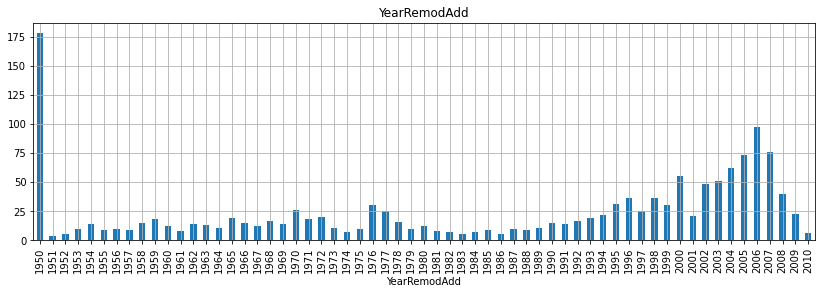

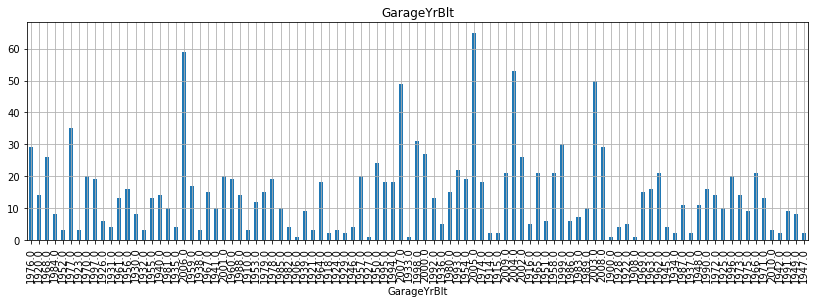

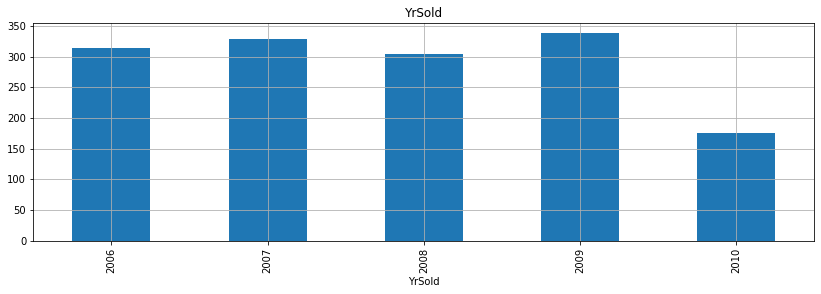

In [22]:
for fea in year_fea:
  data = train.copy()
  data[fea].value_counts(sort=False).plot(kind='bar')
  plt.xlabel(fea)
  plt.title(fea)
  plt.show()

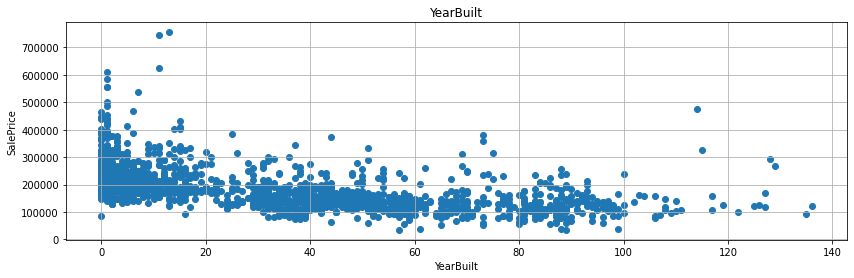

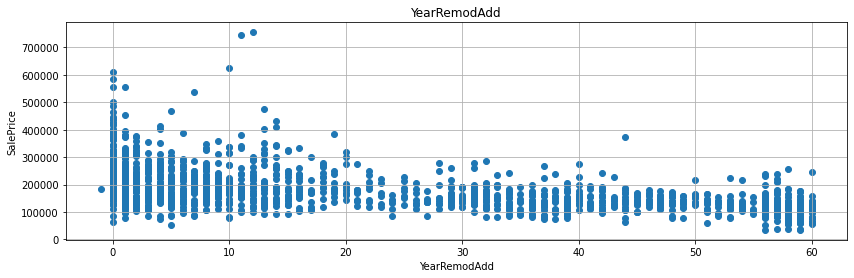

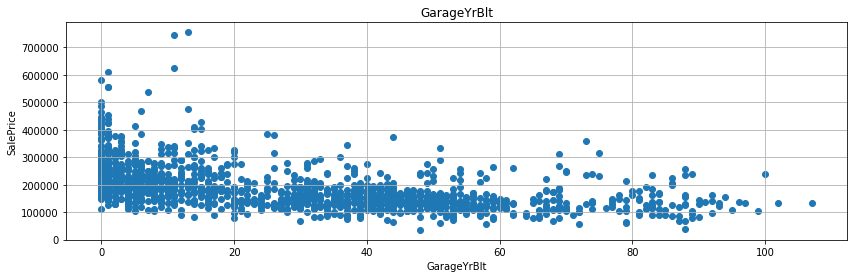

In [23]:
for fea in year_fea:
    if fea!='YrSold': # `YrSold` 변수는 제외 한다.
        data=train.copy() # 이렇게 해주는 것이 좋다. (원본 데이터는 늘 보존할 수 있다)
        data[fea]=data['YrSold']-data[fea] #  여기가 사실 핵심 포인트다. 연수 차이 계산
        plt.scatter(data[fea], data['SalePrice']) # 산점도 그래프를 그린다.
        plt.title(fea)
        plt.xlabel(fea)
        plt.ylabel('SalePrice')
        plt.show()

In [25]:
discrete_vars=[fea for fea in numeric_features if len(train[fea].unique()) < 50 and fea not in year_fea + ['Id']]
print("Discrete Variables Count: {}".format(len(discrete_vars)))

Discrete Variables Count: 17


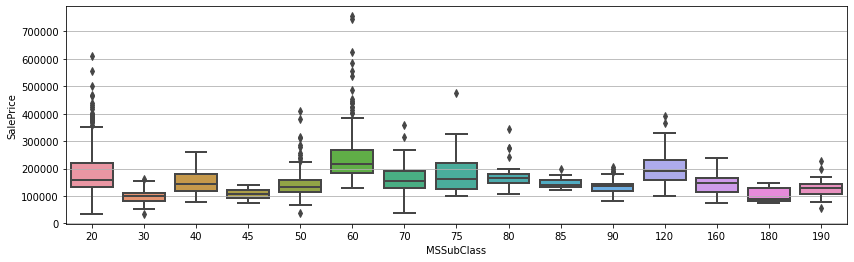

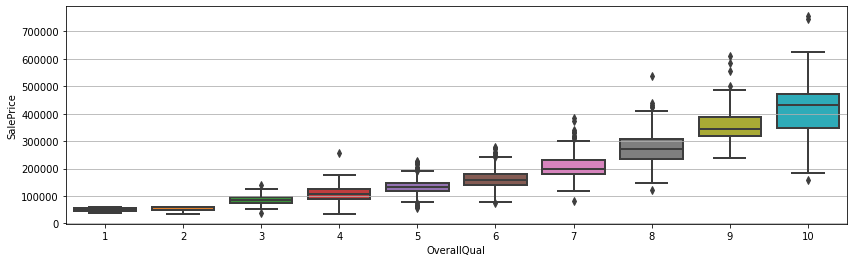

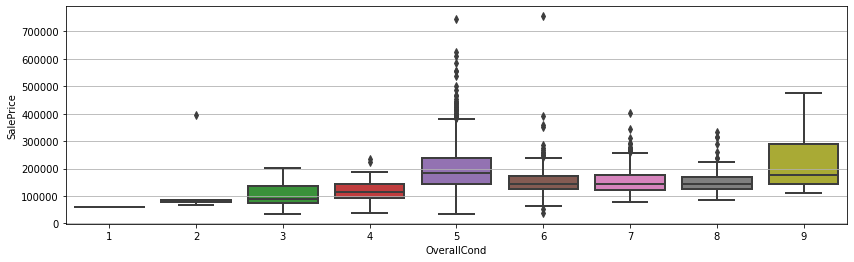

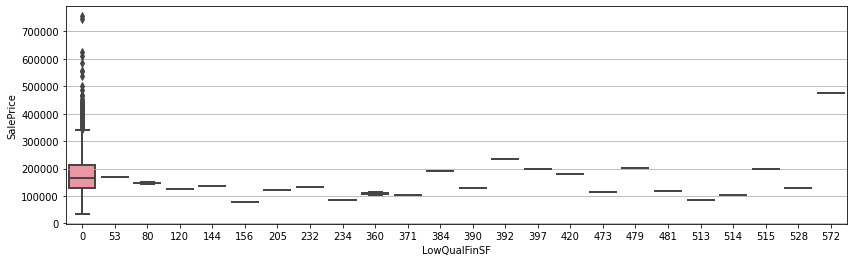

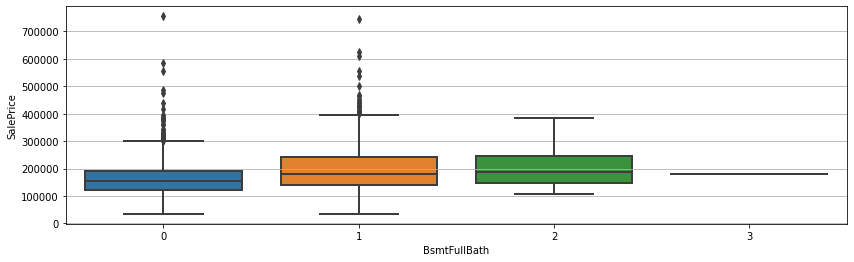

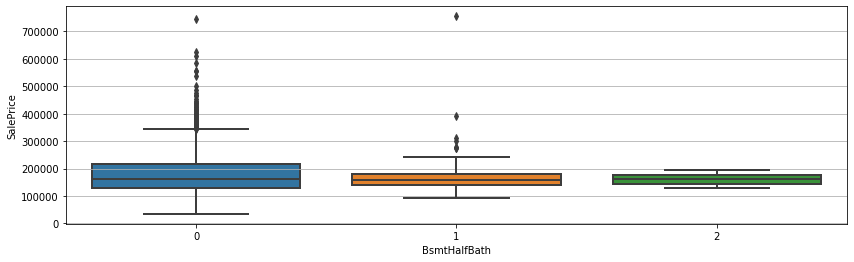

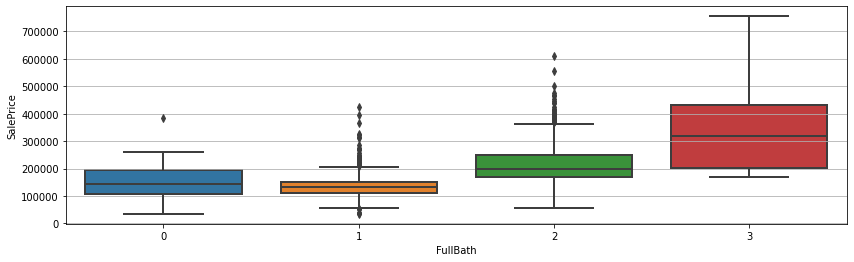

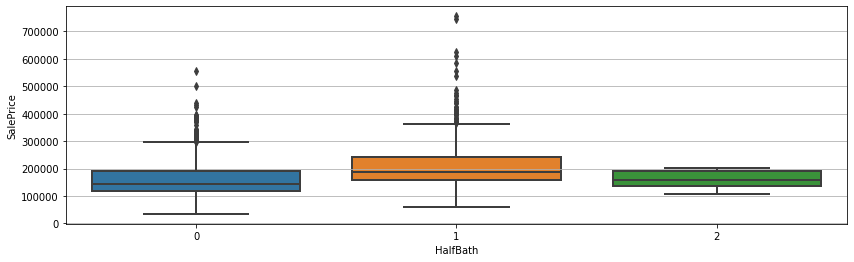

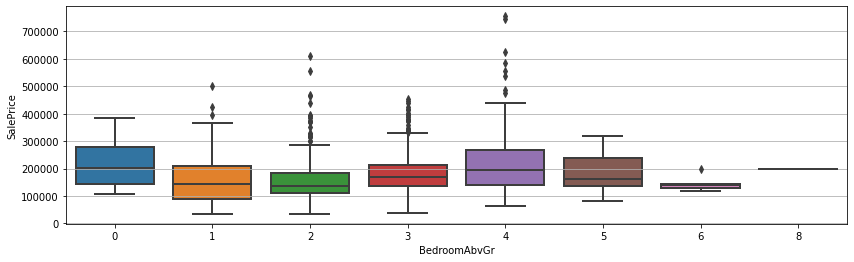

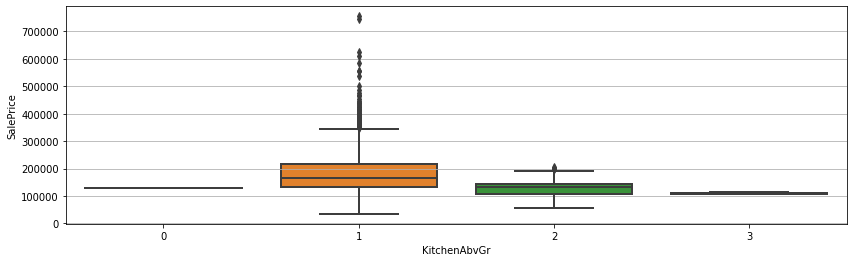

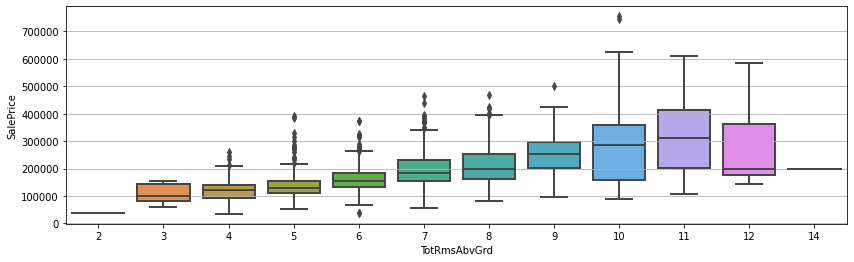

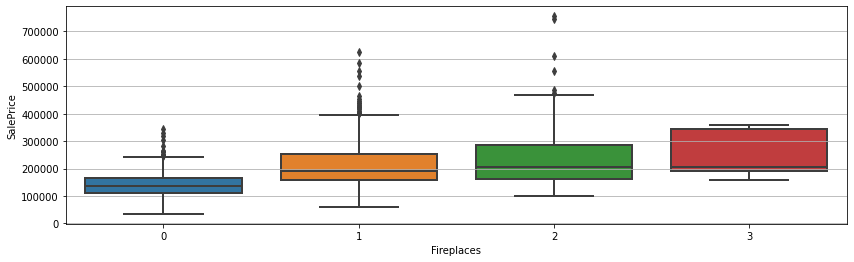

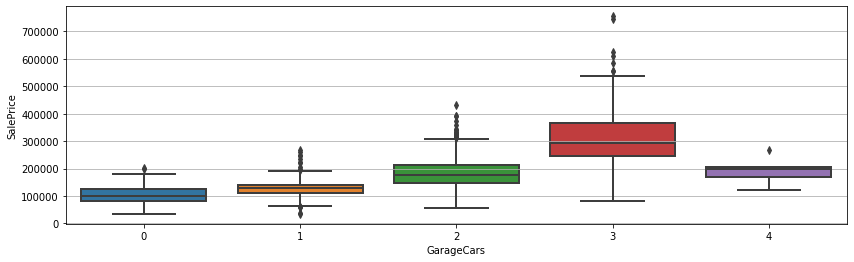

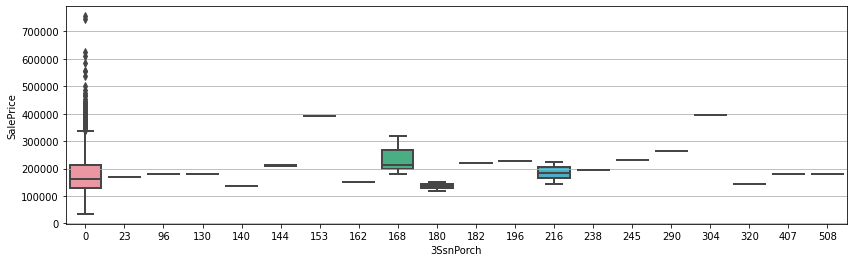

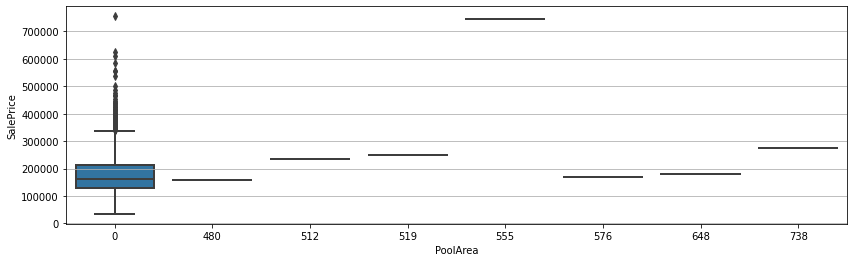

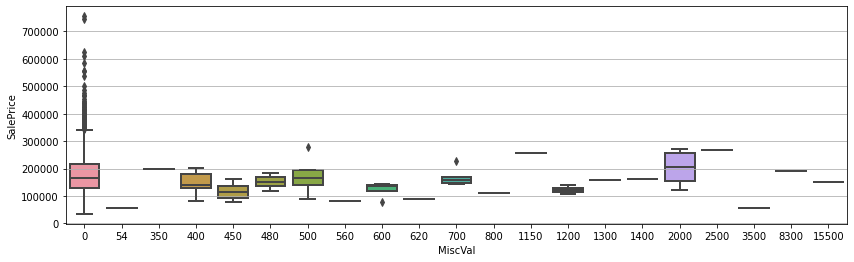

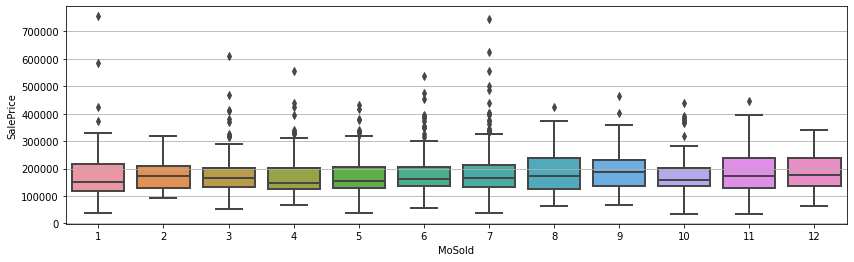

In [26]:
for fea in discrete_vars:
  data = train.copy()
  sns.boxplot(x = fea, y='SalePrice', data = data)
  plt.show()

In [27]:
continuous_vars = [fea for fea in numeric_features if fea not in discrete_vars + year_fea + ['Id'] + ['SalePrice']]
print(continuous_vars)
print("The total number of continuous_vars are: ", len(continuous_vars))

['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch']
The total number of continuous_vars are:  15


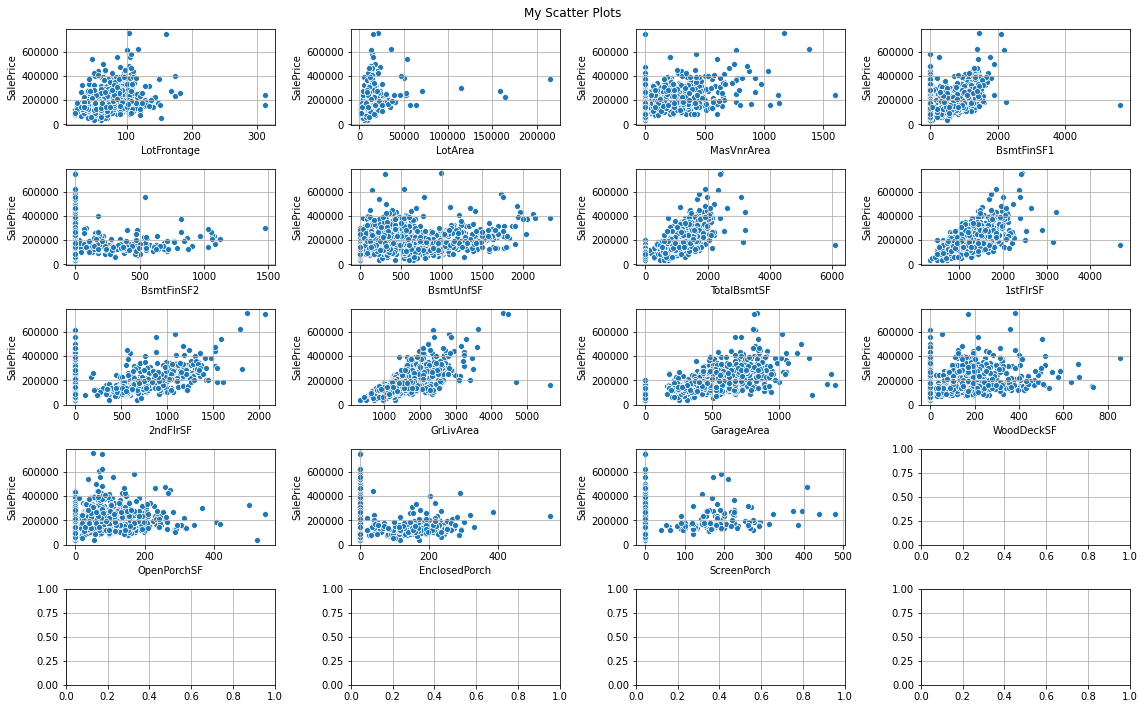

In [28]:
fig, ax = plt.subplots(5, 4, figsize=(16, 10)) # 그래프의 행과 열 지정 및, 이미지 사이즈 지정
data = train.copy()

for i, col in enumerate(data[continuous_vars].columns[0:]): # 좌표 평면 지정
     if i <= 3:
        sns.scatterplot(x=data[col], y=data["SalePrice"], ax=ax[0,i]) # 1행 좌표 평면
     elif i <= 7:
        sns.scatterplot(x=data[col], y=data["SalePrice"], ax=ax[1,i-4]) # 2행 좌표 평면
     elif i <= 11:
        sns.scatterplot(x=data[col], y=data["SalePrice"], ax=ax[2,i-8]) # 3행 좌표 평면
     elif i <= 15:
        sns.scatterplot(x=data[col], y=data["SalePrice"], ax=ax[3,i-12]) # 4행 좌표 평면
     else: 
        sns.scatterplot(x=data[col], y=data["SalePrice"], ax=ax[4,i-16]) # 5행 좌표 평면

fig.suptitle('My Scatter Plots')
fig.tight_layout()
fig.subplots_adjust(top=0.95)